## **Data Preprocessing**

This code uses Multi30k dataset and Spacy for the tokenization. To preprocess the data and create batches, Field and BucketIterator are used. You need to have the dataset in the default directory ("/content"). The dataset file is attached in GitHub Repo.

I am working with torchtext version 0.6.0.

In [ ]:
!pip install torchtext==0.6.0 --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 802.4 kB/s eta 0:00:00


Download the spacy english (en_core_web_sm) and german (de_core_news_sm) models.

In [ ]:
!python -m spacy download de_core_news_sm --quiet
!python -m spacy download en_core_web_sm --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 8.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 68.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import spacy
from torchtext.datasets import Multi30k
from torchtext.data import Field, BucketIterator

batch_size = 32
spacy_english = spacy.load("en_core_web_sm")
spacy_german = spacy.load("de_core_news_sm")

def tokenize_english(text):
    return [token.text for token in spacy_english.tokenizer(text)]

def tokenize_german(text):
    return [token.text for token in spacy_german.tokenizer(text)]


german = Field(init_token = "<sos>", eos_token = "<eos>", lower = True, tokenize = tokenize_german, batch_first = True, fix_length = 30)
english = Field(init_token = "<sos>", eos_token = "<eos>", lower = True, tokenize = tokenize_english, batch_first = True, fix_length = 30)

train_data, dev_data, test_data = Multi30k.splits(exts = (".de", ".en"), fields = (german, english), root = "/content/drive/MyDrive/Colab Notebooks/Transformer/data")

train_iterator, dev_iterator, test_iterator = BucketIterator.splits((train_data, dev_data, test_data), batch_size = batch_size,
                                                                    sort_key = lambda x: len(x.src))

german.build_vocab(train_data, min_freq = 3, max_size = 10000)
english.build_vocab(train_data, min_freq = 3, max_size = 10000)


Extracting some information of the preprocessed data.

In [ ]:
print(f"Total tokens in English vocab: {len(english.vocab.stoi)}")
print(f"Total tokens in German vocab: {len(german.vocab.stoi)}")
print("---------------------------------------------------------------------")

print(f"Num of Samples in Training Data: {len(train_data)}")
print(f"Num of Samples in Devlopment Data: {len(dev_data)}")
print(f"Num of Samples in Testing Data: {len(test_data)}")
print("---------------------------------------------------------------------")

print(f"Num Batches in Training Data: {len(train_iterator)}")
print(f"Num Batches in Development Data: {len(dev_iterator)}")
print(f"Num Batches in Testing Data: {len(test_iterator)}")
print("---------------------------------------------------------------------")

Total tokens in English vocab: 4556
Total tokens in German vocab: 5374
---------------------------------------------------------------------
Num of Samples in Training Data: 29000
Num of Samples in Devlopment Data: 1014
Num of Samples in Testing Data: 1000
---------------------------------------------------------------------
Num Batches in Training Data: 907
Num Batches in Development Data: 32
Num Batches in Testing Data: 32
---------------------------------------------------------------------


## **Transformer Architecture**

This architecture I am making is inspired by the paper "Attention is all you need" published by Ashish Vaswani and others at Google Brain in 2017.


Below is the architecture of original Transformer Neural Network.



                                                                            
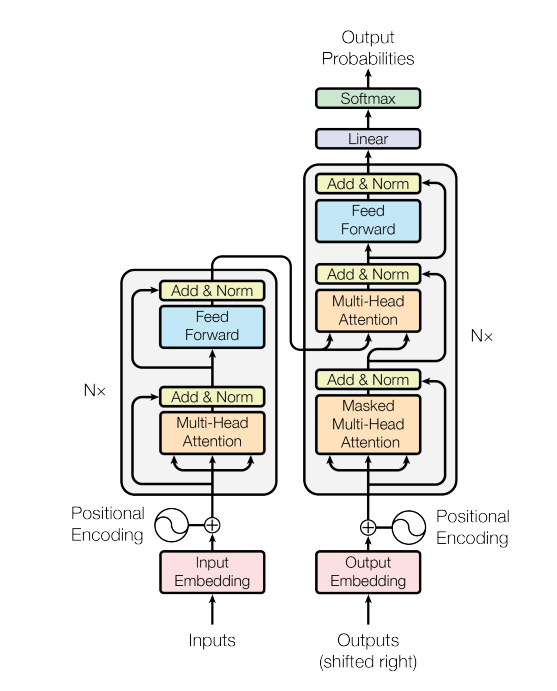

In [ ]:
!pip install torchinfo --quiet

In [ ]:
import math
import torch
import numpy as np
from torch import nn
from torchinfo import summary
from torch.nn.functional import softmax, relu
from torch.utils.tensorboard.writer import SummaryWriter


#### EMBEDDING
class Embedding(nn.Module):

    def __init__(self, d_model: int, vocab_size: int):

        super(Embedding, self).__init__()

        self.embedding = nn.Embedding(vocab_size, d_model)

    def forward(self, input):

        return self.embedding(input)


#### POSITIONAL ENCODING

class PositionalEncoding(nn.Module):
    def __init__(self, seq_len: int, d_model: int):
        super(PositionalEncoding, self).__init__()

        # Create a position tensor (seq_len, 1)
        position = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1)

        # Create a div_term tensor (1, d_model)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))

        # Calculate the positional encodings
        self.pos_enc = torch.zeros(seq_len, d_model)
        self.pos_enc[:, 0::2] = torch.sin(position * div_term)
        self.pos_enc[:, 1::2] = torch.cos(position * div_term)

        # Register buffer so the positional encoding is not a learnable parameter
        self.register_buffer('pos_encoding', self.pos_enc.unsqueeze(0))  # Shape: (1, seq_len, d_model)


    def forward(self, embedding):
        seq_len = embedding.shape[1]
        pos_enc = self.pos_encoding[:, :seq_len, :]

        return embedding + pos_enc


#### MULTI HEAD ATTENTION
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model: int, num_heads: int):
        super(MultiHeadAttention, self).__init__()

        self.num_heads = num_heads
        self.single_head_dim = d_model // self.num_heads
        self.query_matrix = nn.Linear(d_model, d_model)
        self.key_matrix = nn.Linear(d_model, d_model)
        self.value_matrix = nn.Linear(d_model, d_model)
        self.fc = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(0.5)

    def forward(self, pos_emb, mask = None):

        batch_size = pos_emb.shape[0]
        seq_len = pos_emb.shape[1]

        q = self.query_matrix(pos_emb)
        k = self.key_matrix(pos_emb)
        v = self.value_matrix(pos_emb)


        q = q.view(batch_size, seq_len, self.num_heads, self.single_head_dim).transpose(2, 1)
        k = k.view(batch_size, seq_len, self.num_heads, self.single_head_dim).transpose(2, 1)
        v = v.view(batch_size, seq_len, self.num_heads, self.single_head_dim).transpose(2, 1)

        scores = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(self.single_head_dim)

        if mask is not None:
            scores = scores.masked_fill(mask == 0, value = -1e9)

        attention_weights = softmax(scores, dim = -1)

        output = torch.matmul(attention_weights, v).transpose(1, 2)
        output = output.reshape(batch_size, seq_len, -1)


        return attention_weights, self.dropout(self.fc(output))


class CrossAttention(nn.Module):
    def __init__(self, d_model: int, num_heads: int):
        super(CrossAttention, self).__init__()

        self.num_heads = num_heads
        self.single_head_dim = d_model // self.num_heads

        self.key_matrix = nn.Linear(d_model, d_model)
        self.query_matrix = nn.Linear(d_model, d_model)
        self.value_matrix = nn.Linear(d_model, d_model)
        self.fc = nn.Linear(d_model, d_model)


    def forward(self, encoder_output, masked_decoder_output):
        batch_size = masked_decoder_output.shape[0]
        seq_len = masked_decoder_output.shape[1]


        q = self.query_matrix(masked_decoder_output)
        k = self.key_matrix(encoder_output)
        v = self.value_matrix(encoder_output)

        q = q.view(batch_size, seq_len, self.num_heads, self.single_head_dim).transpose(2, 1)
        k = k.view(batch_size, encoder_output.shape[1], self.num_heads, self.single_head_dim).transpose(2, 1)
        v = v.view(batch_size, encoder_output.shape[1], self.num_heads, self.single_head_dim).transpose(2, 1)

        scores = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(self.single_head_dim)
        attention_weights = softmax(scores, dim = -1)
        output = torch.matmul(attention_weights, v).transpose(1, 2)
        output = output.reshape(batch_size, seq_len, -1)

        return attention_weights, self.fc(output)

class AddLayerNorm(nn.Module):
    def __init__(self, d_model: int):
        super(AddLayerNorm, self).__init__()
        self.layer_norm = nn.LayerNorm(d_model)


    def forward(self, res_input1, res_input2):
        residual_output = res_input1 + res_input2
        normalized = self.layer_norm(residual_output)

        return normalized


class FFN(nn.Module):
    def __init__(self, hidden_dim: int, d_model: int):
        super(FFN, self).__init__()

        self.hidden_layer = nn.Linear(d_model, hidden_dim)
        self.output_layer = nn.Linear(hidden_dim, d_model)
        self.dropout = nn.Dropout(0.6)

    def forward(self, normalized_output):
        hidden_output = relu(self.hidden_layer(normalized_output))
        output = self.output_layer(hidden_output)

        return self.dropout(output)

class EncoderBlock(nn.Module):
    def __init__(self, d_model: int, num_heads: int, hidden_dim: int):
        super(EncoderBlock, self).__init__()

        self.multi_head_attention = MultiHeadAttention(d_model, num_heads)
        self.add_layer_norm = AddLayerNorm(d_model)
        self.ffn = FFN(hidden_dim, d_model)

    def forward(self, pos_emb):

        attention_weights, attention_outputs = self.multi_head_attention(pos_emb)
        normalized = self.add_layer_norm(pos_emb, attention_outputs)
        output = self.ffn(normalized)
        normalized_ff_out = self.add_layer_norm(normalized, output)

        return normalized_ff_out


class Encoder(nn.Module):
    def __init__(self, d_model: int, vocab_size: int, seq_len: int, num_heads: int, hidden_dim: int, num_layers: int):
        super(Encoder, self).__init__()

        self.embedding = Embedding(d_model, vocab_size)
        self.pos_enc = PositionalEncoding(seq_len, d_model)
        self.layers = nn.ModuleList([EncoderBlock(d_model, num_heads, hidden_dim) for _ in range(num_layers - 1)])

    def forward(self, input):

        embedding = self.embedding(input)
        pos_emb = self.pos_enc(embedding)

        output = pos_emb

        for layer in self.layers:
            output = layer(output)

        return output


class DecoderBlock(nn.Module):
    def __init__(self, d_model: int, num_heads: int, hidden_dim: int):
        super(DecoderBlock, self).__init__()

        self.multi_head_attention = MultiHeadAttention(d_model, num_heads)
        self.cross_attention = CrossAttention(d_model, num_heads)
        self.add_layer_norm = AddLayerNorm(d_model)
        self.ffn = FFN(hidden_dim, d_model)


    def forward(self, pos_emb, encoder_output, mask = None):
        attention_weights, attention_output = self.multi_head_attention(pos_emb, mask)
        normalized = self.add_layer_norm(pos_emb, attention_output)
        cross_att_weights, cross_att_output = self.cross_attention(encoder_output, attention_output)
        normalized_cross_att = self.add_layer_norm(normalized, cross_att_output)
        output = self.ffn(normalized_cross_att)
        normalized_ff_out = self.add_layer_norm(normalized_cross_att, output)

        return normalized_ff_out



class Decoder(nn.Module):
    def __init__(self, d_model: int, seq_len: int, vocab_size: int, num_heads: int, hidden_dim: int, num_layers: int):
        super(Decoder, self).__init__()

        self.embedding = Embedding(d_model, vocab_size)
        self.pos_enc = PositionalEncoding(seq_len, d_model)
        self.layers = nn.ModuleList([DecoderBlock(d_model, num_heads, hidden_dim) for _ in range(num_layers - 1)])
        self.linear = nn.Linear(d_model, vocab_size)

    def forward(self, input, encoder_output, mask = None):

        embedding = self.embedding(input)
        pos_emb = self.pos_enc(embedding)

        output = pos_emb

        for layer in self.layers:
            output = layer(output, encoder_output, mask)

        output = self.linear(output)

        return output


class Transformer(nn.Module):
    def __init__(self, d_model: int, seq_len: int, src_vocab_size: int, trg_vocab_size: int, hidden_dim: int, num_heads: int, num_layers: int):
        super(Transformer, self).__init__()

        self.encoder = Encoder(d_model, src_vocab_size, seq_len, num_heads, hidden_dim, num_layers).to(device)
        self.decoder = Decoder(d_model, seq_len, trg_vocab_size, num_heads, hidden_dim, num_layers).to(device)


    def forward(self, source, target, mask = None):

        encoder_output = self.encoder(source)
        output = self.decoder(target, encoder_output, mask)

        return output


### HYPERPARAMETERS
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
writer = SummaryWriter(log_dir = "/content/drive/MyDrive/Colab Notebooks/Transformer/runs")
d_model = 350
max_length = 30
src_vocab_size = len(german.vocab.stoi)
trg_vocab_size = len(english.vocab.stoi)
hidden_dim = 1024
num_heads = 2
num_layers = 2

transformer = Transformer(d_model, max_length, src_vocab_size, trg_vocab_size, hidden_dim, num_heads, num_layers).to(device)

writer.add_graph(transformer, (torch.rand(32, 30, device = device).to(torch.long), torch.rand(32, 30, device = device).to(torch.long), torch.tril(torch.ones(30, 30)).unsqueeze(0).unsqueeze(0).to(device)))
summary(transformer, input_data = [torch.rand(32, 30, device = device).to(torch.long), torch.rand(32, 30, device = device).to(torch.long), torch.tril(torch.ones(30, 30)).unsqueeze(0).unsqueeze(0).to(device)])

Layer (type:depth-idx)                        Output Shape              Param #
Transformer                                   [32, 30, 4556]            --
├─Encoder: 1-1                                [32, 30, 350]             --
│    └─Embedding: 2-1                         [32, 30, 350]             --
│    │    └─Embedding: 3-1                    [32, 30, 350]             1,880,900
│    └─PositionalEncoding: 2-2                [32, 30, 350]             --
│    └─ModuleList: 2-3                        --                        --
│    │    └─EncoderBlock: 3-2                 [32, 30, 350]             1,210,274
├─Decoder: 1-2                                [32, 30, 4556]            --
│    └─Embedding: 2-4                         [32, 30, 350]             --
│    │    └─Embedding: 3-3                    [32, 30, 350]             1,594,600
│    └─PositionalEncoding: 2-5                [32, 30, 350]             --
│    └─ModuleList: 2-6                        --                        --

## Training

In [ ]:
from tqdm.notebook import tqdm
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
import torch.nn.functional as F


def translate_sentence(model, sentence, german, english, device, max_length=30):
    model.eval()

    # Tokenize the sentence
    tokenized = [token.text.lower() for token in spacy_german.tokenizer(sentence)]
    tokenized = [german.init_token] + tokenized + [german.eos_token]

    # Convert tokens to indices
    token_indices = [german.vocab.stoi[token] for token in tokenized]

    # Convert to tensor and move to device
    sentence_tensor = torch.LongTensor(token_indices).unsqueeze(0).to(device)

    # Pass through encoder
    with torch.no_grad():
        encoder_out = model.encoder(sentence_tensor)

    # Initialize target sequence with <sos> token
    translated_tokens = [english.vocab.stoi[english.init_token]]

    for _ in range(max_length):
        # Convert last token to tensor
        target_tensor = torch.LongTensor(translated_tokens).unsqueeze(0).to(device)

        # Generate mask for decoder
        trg_mask = torch.tril(torch.ones((len(translated_tokens), len(translated_tokens))).unsqueeze(0).unsqueeze(0).to(device))

        # Decode
        with torch.no_grad():
            output = model.decoder(target_tensor, encoder_out, trg_mask)

        # Get the last predicted token
        next_token_logits = output[:, -1, :]
        next_token = next_token_logits.argmax(1).item()

        # Append the predicted token to the sequence
        translated_tokens.append(next_token)

        # Break if <eos> token is predicted
        if next_token == english.vocab.stoi[english.eos_token]:
            break

    # Convert indices back to tokens
    translated_sentence = [english.vocab.itos[token] for token in translated_tokens]
    return translated_sentence

# Define loss function and optimizer
loss_fn = CrossEntropyLoss(ignore_index=german.vocab.stoi[german.pad_token])
optimizer = Adam(params=transformer.parameters())

# Example sentence to translate
sentence = "Ein Mann in einem blauen Hemd steht auf einer Leiter und reinigt ein Fenster"

num_epochs = 100

for epoch in range(num_epochs):
    train_loss = 0.0
    dev_loss = 0.0

    translated = translate_sentence(transformer, sentence, german, english, device)
    print(f"Translated Sentence after epoch {epoch}:")
    print(translated)

    for batch in tqdm(train_iterator, desc=f"Epoch {epoch + 1} Train Iterator"):
        src = batch.src.to(device)
        trg = batch.trg.to(device)

        trg_input = trg[:, :-1]  # Ignore <eos> token
        trg_output = trg[:, 1:]  # Shift to right

        # Generate target mask
        seq_len = trg_input.shape[1]
        trg_mask = torch.tril(torch.ones((seq_len, seq_len), device=device)).unsqueeze(0).unsqueeze(0)

        # Forward pass
        output = transformer(src, trg_input, trg_mask)

        # Reshape for loss calculation
        output = output.reshape(-1, output.shape[-1])
        trg_output = trg_output.reshape(-1)

        # Calculate loss
        loss = loss_fn(output, trg_output)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    writer.add_scalar("Training Loss", train_loss, epoch)

    for batch in tqdm(dev_iterator, desc = f"Epoch {epoch + 1} Dev Iterator"):
        src = batch.src.to(device)
        trg = batch.trg.to(device)

        trg_input = trg[:, :-1]
        trg_output = trg[:, 1:].reshape(-1)

        seq_len = trg_input.shape[1]

        trg_mask = torch.tril(torch.ones(seq_len, seq_len)).unsqueeze(0).unsqueeze(0).to(device)

        with torch.no_grad():
            output = transformer(src, trg_input, trg_mask)

        output = output.reshape(-1, output.shape[2])
        trg_output = trg_output

        loss = loss_fn(output, trg_output)
        dev_loss += loss.item()

    writer.add_scalar("Developement Loss", dev_loss, epoch)
    print(f"Epoch {epoch + 1} Train Loss: {train_loss / len(train_iterator)} Dev Loss: {dev_loss / len(dev_iterator)}", end = "\n\n")

path = "/content/drive/MyDrive/Colab Notebooks/Transformer/state_dict.pth"
torch.save(transformer.state_dict(), path)


Translated Sentence after epoch 0:
['<sos>', 'poles', 'sweaty', 'hula', 'play', 'rickshaw', 'boss', 'tied', 'cockpit', 'john', 'fork', 'cop', 'skimpy', 'safe', 'bagpipe', 'keep', 'containing', 'motorboat', 'lighting', 'palm', 'shadows', 'lens', 'diner', 'pace', 'twirling', 'scarf', 'tracksuit', 'burning', 'rolled', 'dunks', 'stuck']


Epoch 1 Train Iterator:   0%|          | 0/907 [00:00<?, ?it/s]

Epoch 1 Dev Iterator:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1 Train Loss: 3.2842742043004147 Dev Loss: 2.557548999786377

Translated Sentence after epoch 1:
['<sos>', 'a', 'man', 'in', 'a', 'blue', 'shirt', 'is', 'standing', 'on', 'a', 'window', '.', '<eos>']


Epoch 2 Train Iterator:   0%|          | 0/907 [00:00<?, ?it/s]

Epoch 2 Dev Iterator:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 2 Train Loss: 2.337726568176833 Dev Loss: 2.2155540883541107

Translated Sentence after epoch 2:
['<sos>', 'a', 'man', 'in', 'a', 'blue', 'shirt', 'is', 'standing', 'on', 'a', 'ladder', 'and', 'a', 'ladder', '.', '<eos>']


Epoch 3 Train Iterator:   0%|          | 0/907 [00:00<?, ?it/s]

Epoch 3 Dev Iterator:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 3 Train Loss: 1.9482283329359094 Dev Loss: 2.0674343295395374

Translated Sentence after epoch 3:
['<sos>', 'a', 'man', 'in', 'a', 'blue', 'shirt', 'standing', 'on', 'a', 'ladder', 'and', 'a', 'window', '.', '<eos>']


Epoch 4 Train Iterator:   0%|          | 0/907 [00:00<?, ?it/s]

Epoch 4 Dev Iterator:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 4 Train Loss: 1.69690653770472 Dev Loss: 2.026437733322382

Translated Sentence after epoch 4:
['<sos>', 'a', 'man', 'in', 'a', 'blue', 'shirt', 'stands', 'on', 'a', 'ladder', 'and', 'a', 'ladder', '.', '<eos>']


Epoch 5 Train Iterator:   0%|          | 0/907 [00:00<?, ?it/s]

Epoch 5 Dev Iterator:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 5 Train Loss: 1.5181209974015561 Dev Loss: 2.022762607783079

Translated Sentence after epoch 5:
['<sos>', 'a', 'man', 'in', 'a', 'blue', 'shirt', 'standing', 'on', 'a', 'ladder', 'cleaning', 'a', 'window', '.', '<eos>']


Epoch 6 Train Iterator:   0%|          | 0/907 [00:00<?, ?it/s]

Epoch 6 Dev Iterator:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 6 Train Loss: 1.377506621091605 Dev Loss: 1.9833158180117607

Translated Sentence after epoch 6:
['<sos>', 'a', 'man', 'in', 'a', 'blue', 'shirt', 'is', 'standing', 'on', 'a', 'ladder', 'cleaning', 'a', 'window', '.', '<eos>']


Epoch 7 Train Iterator:   0%|          | 0/907 [00:00<?, ?it/s]

Epoch 7 Dev Iterator:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 7 Train Loss: 1.2637350255625512 Dev Loss: 2.0133306980133057

Translated Sentence after epoch 7:
['<sos>', 'a', 'man', 'in', 'a', 'blue', 'shirt', 'is', 'standing', 'on', 'a', 'ladder', 'cleaning', 'a', 'window', '.', '<eos>']


Epoch 8 Train Iterator:   0%|          | 0/907 [00:00<?, ?it/s]

Epoch 8 Dev Iterator:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 8 Train Loss: 1.1695265054308461 Dev Loss: 2.0426827520132065

Translated Sentence after epoch 8:
['<sos>', 'a', 'man', 'in', 'a', 'blue', 'shirt', 'is', 'standing', 'on', 'a', 'ladder', 'cleaning', 'the', 'window', '.', '<eos>']


Epoch 9 Train Iterator:   0%|          | 0/907 [00:00<?, ?it/s]

Epoch 9 Dev Iterator:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 9 Train Loss: 1.0862459796003365 Dev Loss: 2.0908211432397366

Translated Sentence after epoch 9:
['<sos>', 'a', 'man', 'in', 'a', 'blue', 'shirt', 'standing', 'on', 'a', 'ladder', 'cleaning', 'a', 'ladder', '.', '<eos>']


Epoch 10 Train Iterator:   0%|          | 0/907 [00:00<?, ?it/s]

Epoch 10 Dev Iterator:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 10 Train Loss: 1.0190065462376343 Dev Loss: 2.1081798896193504

Translated Sentence after epoch 10:
['<sos>', 'a', 'man', 'in', 'a', 'blue', 'shirt', 'and', 'a', 'window', 'and', 'washes', 'a', 'window', 'and', 'a', 'window', '.', '<eos>']


Epoch 11 Train Iterator:   0%|          | 0/907 [00:00<?, ?it/s]

Epoch 11 Dev Iterator:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 11 Train Loss: 0.9586892775953013 Dev Loss: 2.141334857791662

Translated Sentence after epoch 11:
['<sos>', 'a', 'man', 'in', 'a', 'blue', 'shirt', 'standing', 'on', 'a', 'ladder', 'cleaning', 'a', 'ladder', '.', '<eos>']


Epoch 12 Train Iterator:   0%|          | 0/907 [00:00<?, ?it/s]

Epoch 12 Dev Iterator:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 12 Train Loss: 0.9071051709049986 Dev Loss: 2.187028743326664

Translated Sentence after epoch 12:
['<sos>', 'a', 'man', 'in', 'a', 'blue', 'shirt', 'stands', 'on', 'a', 'ladder', 'cleaning', 'a', 'ladder', 'cleaning', 'a', 'ladder', '.', '<eos>']


Epoch 13 Train Iterator:   0%|          | 0/907 [00:00<?, ?it/s]

Epoch 13 Dev Iterator:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 13 Train Loss: 0.8583423800873257 Dev Loss: 2.2341855466365814

Translated Sentence after epoch 13:
['<sos>', 'a', 'man', 'in', 'a', 'blue', 'shirt', 'standing', 'on', 'a', 'ladder', 'cleaning', 'a', 'ladder', 'cleaning', 'a', 'window', '.', '<eos>']


Epoch 14 Train Iterator:   0%|          | 0/907 [00:00<?, ?it/s]

Epoch 14 Dev Iterator:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 14 Train Loss: 0.8176720456488209 Dev Loss: 2.2512438409030437

Translated Sentence after epoch 14:
['<sos>', 'a', 'man', 'in', 'a', 'blue', 'shirt', 'is', 'standing', 'on', 'a', 'ladder', 'cleaning', 'a', 'window', '.', '<eos>']


Epoch 15 Train Iterator:   0%|          | 0/907 [00:00<?, ?it/s]

Epoch 15 Dev Iterator:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 15 Train Loss: 0.7814497591839341 Dev Loss: 2.3053621649742126

Translated Sentence after epoch 15:
['<sos>', 'a', 'man', 'in', 'a', 'blue', 'shirt', 'is', 'standing', 'on', 'a', 'ladder', 'cleaning', 'a', 'window', '.', '<eos>']


Epoch 16 Train Iterator:   0%|          | 0/907 [00:00<?, ?it/s]

Epoch 16 Dev Iterator:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 16 Train Loss: 0.7504098137723572 Dev Loss: 2.318355944007635

Translated Sentence after epoch 16:
['<sos>', 'a', 'man', 'in', 'a', 'blue', 'shirt', 'is', 'standing', 'on', 'a', 'ladder', 'cleaning', 'a', 'window', '.', '<eos>']


Epoch 17 Train Iterator:   0%|          | 0/907 [00:00<?, ?it/s]

Epoch 17 Dev Iterator:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 17 Train Loss: 0.7215982821113877 Dev Loss: 2.3908716700971127

Translated Sentence after epoch 17:
['<sos>', 'a', 'man', 'in', 'a', 'blue', 'shirt', 'is', 'standing', 'on', 'a', 'ladder', 'cleaning', 'a', 'ladder', 'cleaning', 'a', 'ladder', '.', '<eos>']


Epoch 18 Train Iterator:   0%|          | 0/907 [00:00<?, ?it/s]

Epoch 18 Dev Iterator:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 18 Train Loss: 0.6919915937667644 Dev Loss: 2.4155529737472534

Translated Sentence after epoch 18:
['<sos>', 'a', 'man', 'in', 'a', 'blue', 'shirt', 'is', 'standing', 'on', 'a', 'ladder', 'cleaning', 'a', 'window', '.', '<eos>']


Epoch 19 Train Iterator:   0%|          | 0/907 [00:00<?, ?it/s]

Epoch 19 Dev Iterator:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 19 Train Loss: 0.6671807212301231 Dev Loss: 2.451054260134697

Translated Sentence after epoch 19:
['<sos>', 'a', 'man', 'in', 'a', 'blue', 'shirt', 'cleaning', 'up', 'a', 'ladder', 'and', 'cleaning', 'a', 'window', '.', '<eos>']


Epoch 20 Train Iterator:   0%|          | 0/907 [00:00<?, ?it/s]

Epoch 20 Dev Iterator:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 20 Train Loss: 0.6445716706565617 Dev Loss: 2.464846607297659

Translated Sentence after epoch 20:
['<sos>', 'a', 'man', 'in', 'a', 'blue', 'shirt', 'cleaning', 'a', 'ladder', 'cleaning', 'a', 'ladder', 'cleaning', 'a', 'ladder', '.', '<eos>']


Epoch 21 Train Iterator:   0%|          | 0/907 [00:00<?, ?it/s]

Epoch 21 Dev Iterator:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 21 Train Loss: 0.627527582474554 Dev Loss: 2.52075207978487

Translated Sentence after epoch 21:
['<sos>', 'a', 'man', 'in', 'a', 'blue', 'shirt', 'is', 'standing', 'on', 'a', 'ladder', 'cleaning', 'a', 'window', '.', '<eos>']


Epoch 22 Train Iterator:   0%|          | 0/907 [00:00<?, ?it/s]

Epoch 22 Dev Iterator:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 22 Train Loss: 0.6122996792969394 Dev Loss: 2.552107624709606

Translated Sentence after epoch 22:
['<sos>', 'a', 'man', 'in', 'a', 'blue', 'shirt', 'cleaning', 'up', 'a', 'ladder', 'cleaning', 'a', 'window', '.', '<eos>']


Epoch 23 Train Iterator:   0%|          | 0/907 [00:00<?, ?it/s]

Epoch 23 Dev Iterator:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 23 Train Loss: 0.5935475486510381 Dev Loss: 2.55219054967165

Translated Sentence after epoch 23:
['<sos>', 'a', 'man', 'in', 'a', 'blue', 'shirt', 'is', 'standing', 'on', 'a', 'ladder', 'and', 'window', '.', '<eos>']


Epoch 24 Train Iterator:   0%|          | 0/907 [00:00<?, ?it/s]

Epoch 24 Dev Iterator:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 24 Train Loss: 0.5744273961247525 Dev Loss: 2.5626468770205975

Translated Sentence after epoch 24:
['<sos>', 'a', 'man', 'in', 'a', 'blue', 'shirt', 'stands', 'on', 'a', 'ladder', 'cleaning', 'a', 'window', '.', '<eos>']


Epoch 25 Train Iterator:   0%|          | 0/907 [00:00<?, ?it/s]

Epoch 25 Dev Iterator:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 25 Train Loss: 0.5565867141759908 Dev Loss: 2.602112054824829

Translated Sentence after epoch 25:
['<sos>', 'a', 'man', 'in', 'a', 'blue', 'shirt', 'is', 'standing', 'on', 'a', 'ladder', 'cleaning', 'a', 'window', '.', '<eos>']


Epoch 26 Train Iterator:   0%|          | 0/907 [00:00<?, ?it/s]

Epoch 26 Dev Iterator:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 26 Train Loss: 0.5424988627959507 Dev Loss: 2.667886260896921

Translated Sentence after epoch 26:
['<sos>', 'a', 'man', 'in', 'a', 'blue', 'shirt', 'is', 'standing', 'on', 'a', 'ladder', 'cleaning', 'a', 'window', '.', '<eos>']


Epoch 27 Train Iterator:   0%|          | 0/907 [00:00<?, ?it/s]

Epoch 27 Dev Iterator:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 27 Train Loss: 0.5346731772562109 Dev Loss: 2.6778038181364536

Translated Sentence after epoch 27:
['<sos>', 'a', 'man', 'in', 'a', 'blue', 'shirt', 'is', 'standing', 'on', 'a', 'ladder', 'cleaning', 'a', 'window', '.', '<eos>']


Epoch 28 Train Iterator:   0%|          | 0/907 [00:00<?, ?it/s]

Epoch 28 Dev Iterator:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 28 Train Loss: 0.5199566747676971 Dev Loss: 2.6804663501679897

Translated Sentence after epoch 28:
['<sos>', 'a', 'man', 'in', 'a', 'blue', 'shirt', 'is', 'standing', 'on', 'a', 'ladder', 'painting', 'on', 'a', 'ladder', '.', '<eos>']


Epoch 29 Train Iterator:   0%|          | 0/907 [00:00<?, ?it/s]

Epoch 29 Dev Iterator:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 29 Train Loss: 0.5133453076900432 Dev Loss: 2.717947017401457

Translated Sentence after epoch 29:
['<sos>', 'a', 'man', 'in', 'a', 'blue', 'shirt', 'is', 'standing', 'on', 'a', 'ladder', 'cleaning', 'a', 'window', '.', '<eos>']


Epoch 30 Train Iterator:   0%|          | 0/907 [00:00<?, ?it/s]

Epoch 30 Dev Iterator:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 30 Train Loss: 0.48977506568176876 Dev Loss: 2.7672114148736

Translated Sentence after epoch 30:
['<sos>', 'a', 'man', 'in', 'a', 'blue', 'shirt', 'is', 'standing', 'on', 'a', 'ladder', ',', 'eating', 'a', 'department', '.', '<eos>']


Epoch 31 Train Iterator:   0%|          | 0/907 [00:00<?, ?it/s]

Epoch 31 Dev Iterator:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 31 Train Loss: 0.48490420289444425 Dev Loss: 2.7751657776534557

Translated Sentence after epoch 31:
['<sos>', 'a', 'man', 'in', 'a', 'blue', 'shirt', 'is', 'standing', 'on', 'a', 'ladder', 'painting', 'a', 'window', '.', '<eos>']


Epoch 32 Train Iterator:   0%|          | 0/907 [00:00<?, ?it/s]

Epoch 32 Dev Iterator:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 32 Train Loss: 0.4764581902615948 Dev Loss: 2.8255144022405148

Translated Sentence after epoch 32:
['<sos>', 'a', 'man', 'in', 'a', 'blue', 'shirt', 'is', 'standing', 'on', 'a', 'ladder', '.', '<eos>']


Epoch 33 Train Iterator:   0%|          | 0/907 [00:00<?, ?it/s]

Epoch 33 Dev Iterator:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 33 Train Loss: 0.46406536515650176 Dev Loss: 2.812701351940632

Translated Sentence after epoch 33:
['<sos>', 'a', 'man', 'in', 'a', 'blue', 'shirt', 'standing', 'up', 'on', 'a', 'ladder', 'cleaning', 'up', 'a', 'window', '.', '<eos>']


Epoch 34 Train Iterator:   0%|          | 0/907 [00:00<?, ?it/s]

Epoch 34 Dev Iterator:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 34 Train Loss: 0.46051157155005384 Dev Loss: 2.8200816176831722

Translated Sentence after epoch 34:
['<sos>', 'a', 'man', 'in', 'a', 'blue', 'shirt', 'is', 'standing', 'on', 'a', 'ladder', 'cleaning', 'a', 'window', '.', '<eos>']


Epoch 35 Train Iterator:   0%|          | 0/907 [00:00<?, ?it/s]

Epoch 35 Dev Iterator:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 35 Train Loss: 0.4464525411843991 Dev Loss: 2.8413701876997948

Translated Sentence after epoch 35:
['<sos>', 'a', 'man', 'in', 'a', 'blue', 'shirt', 'is', 'standing', 'on', 'a', 'ladder', 'cleaning', 'a', 'window', '.', '<eos>']


Epoch 36 Train Iterator:   0%|          | 0/907 [00:00<?, ?it/s]

Epoch 36 Dev Iterator:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 36 Train Loss: 0.43890602845604126 Dev Loss: 2.8710785508155823

Translated Sentence after epoch 36:
['<sos>', 'a', 'man', 'in', 'a', 'blue', 'shirt', 'is', 'standing', 'on', 'a', 'ladder', 'cleaning', 'a', 'window', '.', '<eos>']


Epoch 37 Train Iterator:   0%|          | 0/907 [00:00<?, ?it/s]

Epoch 37 Dev Iterator:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 37 Train Loss: 0.43413289412116796 Dev Loss: 2.912070982158184

Translated Sentence after epoch 37:
['<sos>', 'a', 'man', 'in', 'a', 'blue', 'shirt', 'standing', 'on', 'a', 'ladder', 'propped', 'and', 'window', '.', '<eos>']


Epoch 38 Train Iterator:   0%|          | 0/907 [00:00<?, ?it/s]

Epoch 38 Dev Iterator:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 38 Train Loss: 0.42976998967398883 Dev Loss: 2.8819749876856804

Translated Sentence after epoch 38:
['<sos>', 'a', 'man', 'in', 'a', 'blue', 'shirt', 'is', 'standing', 'on', 'a', 'ladder', 'cleaning', 'a', 'window', '.', '<eos>']


Epoch 39 Train Iterator:   0%|          | 0/907 [00:00<?, ?it/s]

Epoch 39 Dev Iterator:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 39 Train Loss: 0.4210732943463615 Dev Loss: 2.9561110623180866

Translated Sentence after epoch 39:
['<sos>', 'a', 'man', 'in', 'a', 'blue', 'shirt', 'is', 'standing', 'on', 'a', 'ladder', 'cleaning', 'a', 'window', '.', '<eos>']


Epoch 40 Train Iterator:   0%|          | 0/907 [00:00<?, ?it/s]

Epoch 40 Dev Iterator:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 40 Train Loss: 0.40784737080039896 Dev Loss: 2.939905811101198

Translated Sentence after epoch 40:
['<sos>', 'a', 'man', 'in', 'a', 'blue', 'shirt', 'is', 'standing', 'on', 'a', 'ladder', 'cleaning', 'a', 'window', '.', '<eos>']


Epoch 41 Train Iterator:   0%|          | 0/907 [00:00<?, ?it/s]

Epoch 41 Dev Iterator:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 41 Train Loss: 0.40120122303247713 Dev Loss: 2.9930583387613297

Translated Sentence after epoch 41:
['<sos>', 'a', 'man', 'in', 'a', 'blue', 'shirt', ',', 'standing', 'on', 'a', 'ladder', ',', 'cleaning', 'a', 'window', '.', '<eos>']


Epoch 42 Train Iterator:   0%|          | 0/907 [00:00<?, ?it/s]

Epoch 42 Dev Iterator:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 42 Train Loss: 0.39681191868923993 Dev Loss: 3.013519801199436

Translated Sentence after epoch 42:
['<sos>', 'a', 'man', 'in', 'a', 'blue', 'shirt', 'is', 'standing', 'on', 'a', 'ladder', 'cleaning', 'a', 'window', '.', '<eos>']


Epoch 43 Train Iterator:   0%|          | 0/907 [00:00<?, ?it/s]

Epoch 43 Dev Iterator:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 43 Train Loss: 0.3899400677971435 Dev Loss: 3.014530662447214

Translated Sentence after epoch 43:
['<sos>', 'a', 'man', 'in', 'a', 'blue', 'shirt', 'is', 'standing', 'on', 'a', 'ladder', 'cleaning', 'a', 'window', '.', '<eos>']


Epoch 44 Train Iterator:   0%|          | 0/907 [00:00<?, ?it/s]

Epoch 44 Dev Iterator:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 44 Train Loss: 0.39219222000113135 Dev Loss: 3.022531606256962

Translated Sentence after epoch 44:
['<sos>', 'a', 'man', 'in', 'a', 'blue', 'shirt', 'is', 'standing', 'on', 'a', 'ladder', 'cleaning', 'a', 'ladder', '.', '<eos>']


Epoch 45 Train Iterator:   0%|          | 0/907 [00:00<?, ?it/s]

Epoch 45 Dev Iterator:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 45 Train Loss: 0.37942230376151065 Dev Loss: 3.047202490270138

Translated Sentence after epoch 45:
['<sos>', 'a', 'man', 'in', 'a', 'blue', 'shirt', 'is', 'standing', 'on', 'a', 'ladder', 'cleaning', 'a', 'window', '.', '<eos>']


Epoch 46 Train Iterator:   0%|          | 0/907 [00:00<?, ?it/s]

Epoch 46 Dev Iterator:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 46 Train Loss: 0.3771802155422139 Dev Loss: 3.069386661052704

Translated Sentence after epoch 46:
['<sos>', 'a', 'man', 'in', 'a', 'blue', 'shirt', 'cleaning', 'a', 'ladder', 'cleaning', 'a', 'window', '.', '<eos>']


Epoch 47 Train Iterator:   0%|          | 0/907 [00:00<?, ?it/s]

Epoch 47 Dev Iterator:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 47 Train Loss: 0.3694305625120886 Dev Loss: 3.0833679735660553

Translated Sentence after epoch 47:
['<sos>', 'a', 'man', 'wearing', 'a', 'blue', 'shirt', 'standing', 'on', 'a', 'ladder', 'cleaning', 'a', 'ladder', '.', '<eos>']


Epoch 48 Train Iterator:   0%|          | 0/907 [00:00<?, ?it/s]

Epoch 48 Dev Iterator:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 48 Train Loss: 0.3663813182478309 Dev Loss: 3.114478260278702

Translated Sentence after epoch 48:
['<sos>', 'a', 'man', 'in', 'a', 'blue', 'shirt', 'is', 'standing', 'on', 'a', 'ladder', 'cleaning', 'a', 'window', '.', '<eos>']


Epoch 49 Train Iterator:   0%|          | 0/907 [00:00<?, ?it/s]

Epoch 49 Dev Iterator:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 49 Train Loss: 0.3613276647233385 Dev Loss: 3.127147927880287

Translated Sentence after epoch 49:
['<sos>', 'a', 'man', 'in', 'a', 'blue', 'shirt', 'is', 'standing', 'on', 'a', 'ladder', 'cleaning', 'a', 'window', '.', '<eos>']


Epoch 50 Train Iterator:   0%|          | 0/907 [00:00<?, ?it/s]

Epoch 50 Dev Iterator:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 50 Train Loss: 0.3548190197450455 Dev Loss: 3.1780129447579384

Translated Sentence after epoch 50:
['<sos>', 'a', 'man', 'in', 'a', 'blue', 'shirt', 'is', 'standing', 'on', 'a', 'ladder', 'cleaning', 'a', 'window', '.', '<eos>']


Epoch 51 Train Iterator:   0%|          | 0/907 [00:00<?, ?it/s]

Epoch 51 Dev Iterator:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 51 Train Loss: 0.3511331088126297 Dev Loss: 3.1644435599446297

Translated Sentence after epoch 51:
['<sos>', 'a', 'man', 'in', 'a', 'blue', 'shirt', 'is', 'standing', 'on', 'a', 'ladder', '.', '<eos>']


Epoch 52 Train Iterator:   0%|          | 0/907 [00:00<?, ?it/s]

Epoch 52 Dev Iterator:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 52 Train Loss: 0.3441009660309967 Dev Loss: 3.199774630367756

Translated Sentence after epoch 52:
['<sos>', 'a', 'man', 'in', 'a', 'blue', 'shirt', 'is', 'on', 'a', 'ladder', 'cleaning', 'up', 'a', 'window', '.', '<eos>']


Epoch 53 Train Iterator:   0%|          | 0/907 [00:00<?, ?it/s]

Epoch 53 Dev Iterator:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 53 Train Loss: 0.34110282307291506 Dev Loss: 3.22228816896677

Translated Sentence after epoch 53:
['<sos>', 'a', 'man', 'in', 'a', 'blue', 'shirt', 'is', 'standing', 'on', 'a', 'ladder', 'cleaning', 'a', 'window', '.', '<eos>']


Epoch 54 Train Iterator:   0%|          | 0/907 [00:00<?, ?it/s]

Epoch 54 Dev Iterator:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 54 Train Loss: 0.34020646085681305 Dev Loss: 3.203009746968746

Translated Sentence after epoch 54:
['<sos>', 'a', 'man', 'in', 'a', 'blue', 'shirt', 'standing', 'on', 'a', 'ladder', 'cleaning', 'a', 'window', '.', '<eos>']


Epoch 55 Train Iterator:   0%|          | 0/907 [00:00<?, ?it/s]

Epoch 55 Dev Iterator:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 55 Train Loss: 0.33720092161619153 Dev Loss: 3.1901253014802933

Translated Sentence after epoch 55:
['<sos>', 'a', 'man', 'in', 'a', 'blue', 'shirt', 'is', 'standing', 'on', 'a', 'ladder', 'cleaning', 'up', 'a', 'window', '.', '<eos>']


Epoch 56 Train Iterator:   0%|          | 0/907 [00:00<?, ?it/s]

Epoch 56 Dev Iterator:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 56 Train Loss: 0.3340199030812546 Dev Loss: 3.18637815117836

Translated Sentence after epoch 56:
['<sos>', 'a', 'man', 'in', 'a', 'blue', 'shirt', 'is', 'standing', 'on', 'a', 'ladder', 'cleaning', 'a', 'window', '.', '<eos>']


Epoch 57 Train Iterator:   0%|          | 0/907 [00:00<?, ?it/s]

Epoch 57 Dev Iterator:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 57 Train Loss: 0.32193977227218884 Dev Loss: 3.2217771634459496

Translated Sentence after epoch 57:
['<sos>', 'a', 'man', 'in', 'a', 'blue', 'shirt', 'is', 'standing', 'on', 'a', 'ladder', 'cleaning', 'a', 'window', '.', '<eos>']


Epoch 58 Train Iterator:   0%|          | 0/907 [00:00<?, ?it/s]

Epoch 58 Dev Iterator:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 58 Train Loss: 0.32471758731802086 Dev Loss: 3.211330734193325

Translated Sentence after epoch 58:
['<sos>', 'a', 'man', 'in', 'a', 'blue', 'shirt', 'is', 'standing', 'on', 'a', 'ladder', 'cleaning', 'a', 'window', '.', '<eos>']


Epoch 59 Train Iterator:   0%|          | 0/907 [00:00<?, ?it/s]

Epoch 59 Dev Iterator:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 59 Train Loss: 0.3193771591391558 Dev Loss: 3.214797854423523

Translated Sentence after epoch 59:
['<sos>', 'a', 'man', 'in', 'a', 'blue', 'shirt', 'standing', 'on', 'a', 'ladder', 'cleaning', 'a', 'window', '.', '<eos>']


Epoch 60 Train Iterator:   0%|          | 0/907 [00:00<?, ?it/s]

Epoch 60 Dev Iterator:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 60 Train Loss: 0.31609644966719563 Dev Loss: 3.251690059900284

Translated Sentence after epoch 60:
['<sos>', 'a', 'man', 'in', 'a', 'blue', 'shirt', 'is', 'standing', 'on', 'a', 'ladder', 'cleaning', 'a', 'window', '.', '<eos>']


Epoch 61 Train Iterator:   0%|          | 0/907 [00:00<?, ?it/s]

Epoch 61 Dev Iterator:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 61 Train Loss: 0.30810599788086945 Dev Loss: 3.3201968148350716

Translated Sentence after epoch 61:
['<sos>', 'a', 'man', 'in', 'a', 'blue', 'shirt', 'is', 'standing', 'on', 'a', 'ladder', 'cleaning', 'a', 'window', '.', '<eos>']


Epoch 62 Train Iterator:   0%|          | 0/907 [00:00<?, ?it/s]

Epoch 62 Dev Iterator:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 62 Train Loss: 0.3138121904388415 Dev Loss: 3.242066942155361

Translated Sentence after epoch 62:
['<sos>', 'a', 'man', 'in', 'a', 'blue', 'shirt', 'is', 'standing', 'on', 'a', 'ladder', 'cleaning', 'a', 'window', '.', '<eos>']


Epoch 63 Train Iterator:   0%|          | 0/907 [00:00<?, ?it/s]

Epoch 63 Dev Iterator:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 63 Train Loss: 0.31421244860746894 Dev Loss: 3.2363332584500313

Translated Sentence after epoch 63:
['<sos>', 'a', 'man', 'in', 'a', 'blue', 'shirt', 'is', 'standing', 'on', 'a', 'ladder', 'cleaning', 'up', 'a', 'window', '.', '<eos>']


Epoch 64 Train Iterator:   0%|          | 0/907 [00:00<?, ?it/s]

Epoch 64 Dev Iterator:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 64 Train Loss: 0.2990413822701905 Dev Loss: 3.264921620488167

Translated Sentence after epoch 64:
['<sos>', 'a', 'man', 'wearing', 'a', 'blue', 'shirt', 'is', 'standing', 'on', 'a', 'ladder', 'cleaning', 'a', 'window', '.', '<eos>']


Epoch 65 Train Iterator:   0%|          | 0/907 [00:00<?, ?it/s]

Epoch 65 Dev Iterator:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 65 Train Loss: 0.3006465548388619 Dev Loss: 3.2755762487649918

Translated Sentence after epoch 65:
['<sos>', 'a', 'man', 'in', 'a', 'blue', 'shirt', 'is', 'standing', 'on', 'a', 'ladder', 'cleaning', 'a', 'window', '.', '<eos>']


Epoch 66 Train Iterator:   0%|          | 0/907 [00:00<?, ?it/s]

Epoch 66 Dev Iterator:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 66 Train Loss: 0.2953704327279178 Dev Loss: 3.281004510819912

Translated Sentence after epoch 66:
['<sos>', 'a', 'man', 'in', 'a', 'blue', 'shirt', 'is', 'standing', 'on', 'a', 'ladder', 'cleaning', 'a', 'window', '.', '<eos>']


Epoch 67 Train Iterator:   0%|          | 0/907 [00:00<?, ?it/s]

Epoch 67 Dev Iterator:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 67 Train Loss: 0.2942241468726603 Dev Loss: 3.2926771715283394

Translated Sentence after epoch 67:
['<sos>', 'a', 'man', 'in', 'a', 'blue', 'shirt', 'is', 'standing', 'on', 'a', 'ladder', '.', '<eos>']


Epoch 68 Train Iterator:   0%|          | 0/907 [00:00<?, ?it/s]

Epoch 68 Dev Iterator:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 68 Train Loss: 0.2895625564038688 Dev Loss: 3.3159710466861725

Translated Sentence after epoch 68:
['<sos>', 'a', 'man', 'in', 'a', 'blue', 'shirt', 'is', 'standing', 'on', 'a', 'ladder', 'cleaning', 'a', 'window', '.', '<eos>']


Epoch 69 Train Iterator:   0%|          | 0/907 [00:00<?, ?it/s]

Epoch 69 Dev Iterator:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 69 Train Loss: 0.28977439872090843 Dev Loss: 3.3476924747228622

Translated Sentence after epoch 69:
['<sos>', 'a', 'man', 'wearing', 'a', 'blue', 'shirt', 'is', 'standing', 'on', 'a', 'ladder', 'cleaning', 'a', 'window', '.', '<eos>']


Epoch 70 Train Iterator:   0%|          | 0/907 [00:00<?, ?it/s]

Epoch 70 Dev Iterator:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 70 Train Loss: 0.28376794536623695 Dev Loss: 3.298331029713154

Translated Sentence after epoch 70:
['<sos>', 'a', 'man', 'in', 'a', 'blue', 'shirt', 'is', 'standing', 'on', 'a', 'ladder', 'cleaning', 'a', 'window', '.', '<eos>']


Epoch 71 Train Iterator:   0%|          | 0/907 [00:00<?, ?it/s]

Epoch 71 Dev Iterator:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 71 Train Loss: 0.28412846637665895 Dev Loss: 3.335477516055107

Translated Sentence after epoch 71:
['<sos>', 'a', 'man', 'in', 'a', 'blue', 'shirt', 'is', 'standing', 'on', 'a', 'ladder', 'cleaning', 'a', 'window', '.', '<eos>']


Epoch 72 Train Iterator:   0%|          | 0/907 [00:00<?, ?it/s]

Epoch 72 Dev Iterator:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 72 Train Loss: 0.28327172928897393 Dev Loss: 3.340783230960369

Translated Sentence after epoch 72:
['<sos>', 'a', 'man', 'in', 'a', 'blue', 'shirt', 'is', 'standing', 'on', 'a', 'ladder', 'cleaning', 'a', 'window', '.', '<eos>']


Epoch 73 Train Iterator:   0%|          | 0/907 [00:00<?, ?it/s]

Epoch 73 Dev Iterator:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 73 Train Loss: 0.27221590993554223 Dev Loss: 3.393092006444931

Translated Sentence after epoch 73:
['<sos>', 'a', 'man', 'in', 'a', 'blue', 'shirt', 'is', 'standing', 'on', 'a', 'ladder', 'cleaning', 'a', 'window', '.', '<eos>']


Epoch 74 Train Iterator:   0%|          | 0/907 [00:00<?, ?it/s]

Epoch 74 Dev Iterator:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 74 Train Loss: 0.27770353295114364 Dev Loss: 3.3640897944569588

Translated Sentence after epoch 74:
['<sos>', 'a', 'man', 'in', 'a', 'blue', 'shirt', 'is', 'standing', 'on', 'a', 'ladder', 'cleaning', 'a', 'window', '.', '<eos>']


Epoch 75 Train Iterator:   0%|          | 0/907 [00:00<?, ?it/s]

Epoch 75 Dev Iterator:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 75 Train Loss: 0.26953510984433393 Dev Loss: 3.3917849361896515

Translated Sentence after epoch 75:
['<sos>', 'a', 'man', 'in', 'a', 'blue', 'shirt', 'is', 'standing', 'on', 'a', 'ladder', 'cleaning', 'a', 'window', '.', '<eos>']


Epoch 76 Train Iterator:   0%|          | 0/907 [00:00<?, ?it/s]

Epoch 76 Dev Iterator:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 76 Train Loss: 0.26995068829601104 Dev Loss: 3.4090121164917946

Translated Sentence after epoch 76:
['<sos>', 'a', 'man', 'in', 'a', 'blue', 'shirt', 'is', 'on', 'a', 'ladder', 'cleaning', 'a', 'window', '.', '<eos>']


Epoch 77 Train Iterator:   0%|          | 0/907 [00:00<?, ?it/s]

Epoch 77 Dev Iterator:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 77 Train Loss: 0.2680609483670242 Dev Loss: 3.4440222829580307

Translated Sentence after epoch 77:
['<sos>', 'a', 'man', 'in', 'a', 'blue', 'shirt', 'is', 'standing', 'on', 'a', 'ladder', 'cleaning', 'a', 'window', '.', '<eos>']


Epoch 78 Train Iterator:   0%|          | 0/907 [00:00<?, ?it/s]

Epoch 78 Dev Iterator:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 78 Train Loss: 0.26665909028105855 Dev Loss: 3.3982289656996727

Translated Sentence after epoch 78:
['<sos>', 'a', 'man', 'in', 'a', 'blue', 'shirt', 'is', 'standing', 'on', 'a', 'ladder', 'cleaning', 'a', 'window', '.', '<eos>']


Epoch 79 Train Iterator:   0%|          | 0/907 [00:00<?, ?it/s]

Epoch 79 Dev Iterator:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 79 Train Loss: 0.2624919933842982 Dev Loss: 3.4651710465550423

Translated Sentence after epoch 79:
['<sos>', 'a', 'man', 'in', 'a', 'blue', 'shirt', ',', 'standing', 'on', 'a', 'ladder', 'cleaning', 'a', 'window', '.', '<eos>']


Epoch 80 Train Iterator:   0%|          | 0/907 [00:00<?, ?it/s]

Epoch 80 Dev Iterator:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 80 Train Loss: 0.2627901499464599 Dev Loss: 3.4743914678692818

Translated Sentence after epoch 80:
['<sos>', 'a', 'man', 'in', 'a', 'blue', 'shirt', 'is', 'standing', 'up', 'on', 'a', 'ladder', 'cleaning', 'a', 'window', '.', '<eos>']


Epoch 81 Train Iterator:   0%|          | 0/907 [00:00<?, ?it/s]

Epoch 81 Dev Iterator:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 81 Train Loss: 0.2558393897498981 Dev Loss: 3.5145453736186028

Translated Sentence after epoch 81:
['<sos>', 'a', 'man', 'in', 'a', 'blue', 'shirt', 'is', 'standing', 'on', 'a', 'ladder', 'cleaning', 'a', 'window', '.', '<eos>']


Epoch 82 Train Iterator:   0%|          | 0/907 [00:00<?, ?it/s]

Epoch 82 Dev Iterator:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 82 Train Loss: 0.2670363658154024 Dev Loss: 3.414813846349716

Translated Sentence after epoch 82:
['<sos>', 'a', 'man', 'in', 'a', 'blue', 'shirt', 'is', 'on', 'a', 'ladder', 'cleaning', 'a', 'window', '.', '<eos>']


Epoch 83 Train Iterator:   0%|          | 0/907 [00:00<?, ?it/s]

Epoch 83 Dev Iterator:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 83 Train Loss: 0.2559753119156931 Dev Loss: 3.4897036403417587

Translated Sentence after epoch 83:
['<sos>', 'a', 'man', 'in', 'a', 'blue', 'shirt', 'is', 'standing', 'on', 'a', 'ladder', 'cleaning', 'a', 'window', '.', '<eos>']


Epoch 84 Train Iterator:   0%|          | 0/907 [00:00<?, ?it/s]

Epoch 84 Dev Iterator:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 84 Train Loss: 0.24997518583721468 Dev Loss: 3.455620490014553

Translated Sentence after epoch 84:
['<sos>', 'a', 'man', 'in', 'a', 'blue', 'shirt', 'is', 'on', 'a', 'ladder', 'cleaning', 'a', 'window', '.', '<eos>']


Epoch 85 Train Iterator:   0%|          | 0/907 [00:00<?, ?it/s]

Epoch 85 Dev Iterator:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 85 Train Loss: 0.2524486266676226 Dev Loss: 3.469500169157982

Translated Sentence after epoch 85:
['<sos>', 'a', 'man', 'in', 'a', 'blue', 'shirt', 'is', 'standing', 'on', 'a', 'ladder', '.', '<eos>']


Epoch 86 Train Iterator:   0%|          | 0/907 [00:00<?, ?it/s]

Epoch 86 Dev Iterator:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 86 Train Loss: 0.2512626398884606 Dev Loss: 3.477030575275421

Translated Sentence after epoch 86:
['<sos>', 'a', 'man', 'in', 'a', 'blue', 'shirt', 'is', 'on', 'a', 'ladder', 'cleaning', 'a', 'window', '.', '<eos>']


Epoch 87 Train Iterator:   0%|          | 0/907 [00:00<?, ?it/s]

Epoch 87 Dev Iterator:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 87 Train Loss: 0.2472583977659587 Dev Loss: 3.502094402909279

Translated Sentence after epoch 87:
['<sos>', 'a', 'man', 'in', 'a', 'blue', 'shirt', 'is', 'on', 'a', 'ladder', 'cleaning', 'a', 'window', '.', '<eos>']


Epoch 88 Train Iterator:   0%|          | 0/907 [00:00<?, ?it/s]

Epoch 88 Dev Iterator:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 88 Train Loss: 0.24190105128183123 Dev Loss: 3.5293047428131104

Translated Sentence after epoch 88:
['<sos>', 'a', 'man', 'in', 'a', 'blue', 'shirt', 'is', 'standing', 'on', 'a', 'ladder', 'cleaning', 'a', 'window', '.', '<eos>']


Epoch 89 Train Iterator:   0%|          | 0/907 [00:00<?, ?it/s]

Epoch 89 Dev Iterator:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 89 Train Loss: 0.24609700811343 Dev Loss: 3.5076759457588196

Translated Sentence after epoch 89:
['<sos>', 'a', 'man', 'wearing', 'a', 'blue', 'shirt', 'is', 'standing', 'on', 'a', 'ladder', 'cleaning', 'a', 'window', '.', '<eos>']


Epoch 90 Train Iterator:   0%|          | 0/907 [00:00<?, ?it/s]

Epoch 90 Dev Iterator:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 90 Train Loss: 0.24497492503797863 Dev Loss: 3.52887449413538

Translated Sentence after epoch 90:
['<sos>', 'a', 'man', 'in', 'a', 'blue', 'shirt', 'is', 'standing', 'on', 'a', 'ladder', 'cleaning', 'a', 'window', '.', '<eos>']


Epoch 91 Train Iterator:   0%|          | 0/907 [00:00<?, ?it/s]

Epoch 91 Dev Iterator:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 91 Train Loss: 0.234512615123355 Dev Loss: 3.554805316030979

Translated Sentence after epoch 91:
['<sos>', 'a', 'man', 'wearing', 'a', 'blue', 'shirt', 'is', 'on', 'a', 'ladder', 'cleaning', 'a', 'ladder', 'cleaning', 'a', 'window', '.', '<eos>']


Epoch 92 Train Iterator:   0%|          | 0/907 [00:00<?, ?it/s]

Epoch 92 Dev Iterator:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 92 Train Loss: 0.23850995966755964 Dev Loss: 3.596828304231167

Translated Sentence after epoch 92:
['<sos>', 'a', 'man', 'in', 'a', 'blue', 'shirt', 'is', 'on', 'a', 'ladder', 'cleaning', 'a', 'window', '.', '<eos>']


Epoch 93 Train Iterator:   0%|          | 0/907 [00:00<?, ?it/s]

Epoch 93 Dev Iterator:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 93 Train Loss: 0.2376780334157744 Dev Loss: 3.5834758058190346

Translated Sentence after epoch 93:
['<sos>', 'a', 'man', 'in', 'a', 'blue', 'shirt', 'is', 'standing', 'on', 'a', 'ladder', 'cleaning', 'a', 'window', '.', '<eos>']


Epoch 94 Train Iterator:   0%|          | 0/907 [00:00<?, ?it/s]

Epoch 94 Dev Iterator:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 94 Train Loss: 0.23310677037710917 Dev Loss: 3.5441389605402946

Translated Sentence after epoch 94:
['<sos>', 'a', 'man', 'wearing', 'a', 'blue', 'shirt', 'is', 'standing', 'on', 'a', 'ladder', 'cleaning', 'up', 'a', 'window', '.', '<eos>']


Epoch 95 Train Iterator:   0%|          | 0/907 [00:00<?, ?it/s]

Epoch 95 Dev Iterator:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 95 Train Loss: 0.23028749240667054 Dev Loss: 3.5030107721686363

Translated Sentence after epoch 95:
['<sos>', 'a', 'man', 'wearing', 'a', 'blue', 'shirt', 'is', 'standing', 'on', 'a', 'ladder', 'cleaning', 'a', 'window', '.', '<eos>']


Epoch 96 Train Iterator:   0%|          | 0/907 [00:00<?, ?it/s]

Epoch 96 Dev Iterator:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 96 Train Loss: 0.23410518284242235 Dev Loss: 3.4638510942459106

Translated Sentence after epoch 96:
['<sos>', 'a', 'man', 'wearing', 'a', 'blue', 'shirt', 'is', 'standing', 'on', 'a', 'ladder', 'cleaning', 'a', 'window', '.', '<eos>']


Epoch 97 Train Iterator:   0%|          | 0/907 [00:00<?, ?it/s]

Epoch 97 Dev Iterator:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 97 Train Loss: 0.22818670220582724 Dev Loss: 3.5128125846385956

Translated Sentence after epoch 97:
['<sos>', 'a', 'man', 'in', 'a', 'blue', 'shirt', 'is', 'standing', 'on', 'a', 'ladder', 'cleaning', 'a', 'window', '.', '<eos>']


Epoch 98 Train Iterator:   0%|          | 0/907 [00:00<?, ?it/s]

Epoch 98 Dev Iterator:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 98 Train Loss: 0.2308467568412768 Dev Loss: 3.55144339799881

Translated Sentence after epoch 98:
['<sos>', 'a', 'man', 'in', 'a', 'blue', 'shirt', 'standing', 'on', 'a', 'ladder', 'cleaning', 'a', 'window', '.', '<eos>']


Epoch 99 Train Iterator:   0%|          | 0/907 [00:00<?, ?it/s]

Epoch 99 Dev Iterator:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 99 Train Loss: 0.22456437522646086 Dev Loss: 3.527839682996273

Translated Sentence after epoch 99:
['<sos>', 'a', 'man', 'in', 'a', 'blue', 'shirt', 'is', 'standing', 'on', 'a', 'ladder', 'cleaning', 'a', 'window', '.', '<eos>']


Epoch 100 Train Iterator:   0%|          | 0/907 [00:00<?, ?it/s]

Epoch 100 Dev Iterator:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 100 Train Loss: 0.22919671642445152 Dev Loss: 3.512366347014904



## Inference

Inference is the process of using trained model to make predictions on new and unseen data. During inference the decoder part of Transformer becomes auto-regressive, which means it predicts one token at a time. The first input token is a special Start-of-Sequence token to kickstart the decoding process. The first predicted token is then fed to the decoder as input for the next timestep, and the process continues until the max length reaches or the model predicts a special End-of-Sequence token.

I have demostrated to decode either one sentence or multiple sentences.


In [ ]:

def translate(model, data, german, english, device, max_length=30):
    model.eval()

    translated = []

    ## If the input data is a single sentence
    with torch.no_grad():
        if isinstance(data, str):
            tokenized = [token.text.lower() for token in spacy_german.tokenizer(data)]
            tokenized = [german.init_token] + tokenized + [german.eos_token]
            input_ids = [german.vocab.stoi[token] for token in tokenized]
            input_tensor = torch.LongTensor(input_ids).unsqueeze(0).to(device)

            with torch.no_grad():
                encoder_output = model.encoder(input_tensor)

            decoded = [english.vocab.stoi[english.init_token]]

            for _ in range(max_length):
                decoder_input = torch.LongTensor(decoded).unsqueeze(0).to(device)
                trg_mask = torch.tril(torch.ones(len(decoded), len(decoded))).unsqueeze(0).unsqueeze(0).to(device)

                output = model.decoder(decoder_input, encoder_output, trg_mask)

                next_token_logits = output[:, -1, :]

                next_token = next_token_logits.argmax(1).item()

                decoded.append(next_token)

                translated.append(english.vocab.itos[next_token])

                if next_token == english.vocab.stoi[english.eos_token]:
                    break



    ## If the input data is multiple sentences
    with torch.no_grad():
        if isinstance(data, list):
            batch_size = len(data)
            tokenized = [[token.text for token in spacy_german.tokenizer(sentence)] for sentence in data]
            tokenized = [[german.init_token] + seq + [german.eos_token] for seq in tokenized]

            input_ids = [[german.vocab.stoi[token] for token in tokens] for tokens in tokenized]
            input_tensor = torch.LongTensor(input_ids).to(device)

            with torch.no_grad():
                encoder_output = model.encoder(input_tensor)

            translated_sentences = [[english.vocab.stoi[english.init_token]] for _ in range(batch_size)]

            for batch_idx, sample in enumerate(translated_sentences):

                trg_mask = torch.tril(torch.ones(len(translated_sentences[batch_idx]), len(translated_sentences[batch_idx]))).unsqueeze(0).unsqueeze(0).to(device)

                for _ in range(max_length):

                    decoder_input = torch.LongTensor(translated_sentences[batch_idx]).unsqueeze(0).to(device)
                    output = model.decoder(decoder_input, encoder_output[batch_idx, :, :].unsqueeze(0), trg_mask)

                    next_token_logits = output[:, -1, :]
                    next_token = next_token_logits.argmax(1).item()

                    translated_sentences[batch_idx].append(next_token)

                    if next_token == english.vocab.stoi[english.eos_token]:
                        break

            for translations in translated_sentences:
                translated.append([english.vocab.itos[index] for index in translations])

    return translated


sentence = "Zwei Frauen gehen vor dem Gebäude spazieren"


output = translate(transformer, sentence, german, english, device)
print(output)

['two', 'women', 'walk', 'outside', 'of', 'the', 'building', '.', '<eos>']


## Calculating BLEU Score

Calcuating the BLEU (BiLingual Evaluation Understudy) score on the test set.  The BLEU score is a number between zero and one that measures the similarity of the machine-translated text to a set of high quality reference translations. The higher the BLEU Score is the better the translation quality is. I am going to use sacrebleu library to calculate the BLEU Score.

In [ ]:
pip install sacrebleu --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.0/104.0 kB 6.5 MB/s eta 0:00:00


In [ ]:
import sacrebleu
from tqdm.notebook import tqdm

# Reference translations

references = []
candidates = []
translated_sentences = []
correct_sentences = []

for batch in tqdm(test_iterator):
    src = batch.src.to(device)
    trg = batch.trg.to(device)

    trg_input = trg[:, :-1]  # Ignore <eos> token
    trg_output = trg[:, 1:]  # Shift to right

    # Generate target mask
    seq_len = trg_input.shape[1]
    trg_mask = torch.tril(torch.ones((seq_len, seq_len), device=device)).unsqueeze(0).unsqueeze(0)

    # Forward pass
    with torch.no_grad():
        output = transformer(src, trg_input, trg_mask)

    prediction = torch.argmax(output, dim = -1)

    for correct_sentence, predicted_sentence in zip(trg_output, prediction):
        decoded_predicted_sentence = []
        decoded_correct_sentence = []

        for correct_token, predicted_token in zip(correct_sentence, predicted_sentence):
            decoded_correct_sentence.append(english.vocab.itos[correct_token])
            decoded_predicted_sentence.append(english.vocab.itos[predicted_token])

        correct_sentences.append(decoded_correct_sentence)
        translated_sentences.append(decoded_predicted_sentence)


for correct, translated in zip(correct_sentences, translated_sentences):
    references.append(" ".join(correct))
    candidates.append(" ".join(translated))

# Calculate BLEU score
bleu = sacrebleu.corpus_bleu(candidates, [references])
print(f"BLEU score: {bleu.score:.4f}")


  0%|          | 0/32 [00:00<?, ?it/s]

TypeError: BLEU: `refs` should be a sequence of sequence of strings.